## FILTER -> VGG Affine -> GAP -> VGG Zoom

In [1]:
import sys
sys.version

'3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 18:21:58) \n[GCC 7.2.0]'

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cv2
import socket

import numpy as np
from lxml import etree

from os import listdir
from os.path import isfile, join
from datetime import datetime

import tensorflow as tf

from keras import backend as K
from keras.models import model_from_json
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, load_img

Using TensorFlow backend.


In [3]:
hostname=socket.gethostname()

file="hfland"
if hostname=="cellar2":
    SCENE_DIR="/media/winpart/drone/upairtag/"
    ANNO_DIR="/media/winpart/drone/labels/"
else:
    SCENE_DIR="/part/data/upairdrone/upairtag/"
    ANNO_DIR="/part/data/upairdrone/labels/"

SCENE_DIR="./"
ANNO_DIR="./"

scenefile=join(SCENE_DIR,file+".jpg")
print(scenefile)

./hfland.jpg


## VGG16 CAM model

In [4]:
modeldir="./"
model_json=join(modeldir,"vgg16-GAP.v3_arch.json")
model_weight=join(modeldir,"vgg16-GAP.v3weights.h5")

In [5]:
# Model reconstruction from JSON file
with open(model_json, 'r') as f:
    cammodel = model_from_json(f.read())

cammodel.load_weights(model_weight)

# Compile the model
cammodel.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

## VGG16 Affine Model

In [6]:
model_json=join(modeldir,"vgg16-fc1-fc2-12_arch.json")
model_weight=join(modeldir,"vgg16_weights.h5")

In [7]:
# Model reconstruction from JSON file
with open(model_json, 'r') as f:
    vggmodel = model_from_json(f.read())

vggmodel.load_weights(model_weight)

# Compile the model
vggmodel.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

## VGG Zoom Model

In [8]:
model_json=join(modeldir,"vgg16-dataset.facet.v22arch.json")
model_weight=join(modeldir,"vgg16-dataset.facet.v22")

In [9]:
# Model reconstruction from JSON file
with open(model_json, 'r') as f:
    zoommodel = model_from_json(f.read())

zoommodel.load_weights(model_weight)

# Compile the model
zoommodel.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

## Visualisations

In [10]:
def show_rgb(image):
    h,w,c=image.shape
    figure(num=None, figsize=(15, 12), dpi=80, facecolor='w', edgecolor='k')
        
    plt.imshow(image)
    plt.show()

def show_tile(image,title):
    h,w,c=image.shape
    figure(num=None, figsize=(2,2), dpi=80, facecolor='w', edgecolor='k')
    
    plt.title(title)
    plt.imshow(image)
    plt.show()
    


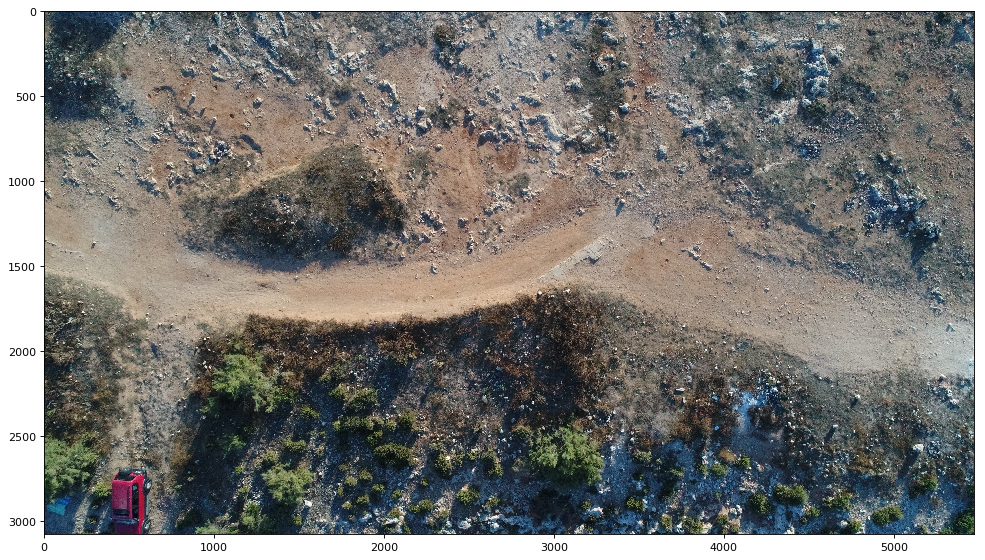

In [11]:
fullimage = cv2.imread(scenefile)
fullimage = cv2.cvtColor(fullimage, cv2.COLOR_BGR2RGB)

show_rgb(fullimage)

## Sliding - Window Affine

In [12]:
crop_image_size = 224
overlap = 32

def slide(orig_image):
    fullimage=orig_image.copy()
    
    ## Size of image - get detection map size
    h,w,c = fullimage.shape
    no_tile_y = int(h/(crop_image_size-overlap))
    no_tile_x = int(w/(crop_image_size-overlap)) 
    detectmap = np.zeros((no_tile_y+1,no_tile_x+1))
    
    nx = 0
    status = 1
    
    for x in range(no_tile_x-1):
        ny = 0
        x_coord = x * (crop_image_size - overlap)
        for y in range(no_tile_y-1):
            
            y_coord = y * (crop_image_size - overlap)
            
            crop_image=fullimage[y_coord:y_coord+crop_image_size,x_coord:x_coord+crop_image_size]
            
            crop_image = crop_image.astype("float") / 255.0
            img = img_to_array(crop_image)
            img = np.expand_dims(img, axis=0)

            try:
                detectmap[ny][nx]= vggmodel.predict(img)[0][1]
            except ValueError:
                print(nx,ny,img.shape)
            ny=ny+1
        nx=nx+1
    return detectmap

inference_map = slide(fullimage)

### VGG CAM method


In [13]:
for i in cammodel.layers:
    if i.name=="conv6":
        output=i.output
    if i.name=="batch_normalization_11":
        classw=i.get_weights()[0]
        
get_output = K.function([cammodel.input], [output, cammodel.layers[-1].output])

In [14]:
def cam_centres(img_in,debug=False):
    
    # Get CAM prediction from tile img_in
    exp_img=img_in.copy()
    [conv_output,preds]=get_output([exp_img])
        
    cam = np.zeros(dtype = np.float32, shape = conv_output.shape[1:3])
    for i, w in enumerate(classw[:]):
        cam+=w*conv_output[0,:,:,i]

    cam /=np.max(cam)
    width=height=224
    cam = cv2.resize(cam, (height, width))
    
    ### Create a heatmap to detect litter within tile
    heatmap = np.ones((height,width,3), np.uint8)*255
    
    ### IMPORTANT THRESHOLD VALUE
    heatmap[np.where(cam < 0.75)] = 0
    
    ### Convert heatmap to image and find contours of mask created
    thresh = cv2.threshold(cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY), 60, 255, cv2.THRESH_BINARY)[1]
    
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[1] 
    
    ### Find Centres
    centres=[]
    cnt=0
    # loop over the contours
    for c in cnts:
        # compute the center of the contour
        M = cv2.moments(c)
        if M["m00"]!=0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX=0
            cY=0
            print("++++++++ERROR+++++++",cnt,len(cnts))
            print(exp_img.shape)
            show_rgb(exp_img[0])
            print(heatmap.shape)
            show_rgb(heatmap)
            print("=======================")
        
        if debug==True:
            print("++++++++DEBUG+++++++",cnt,len(cnts))
            show_rgb(exp_img[0])
            show_rgb(heatmap)
            print("=======================")
        
        dist=0
        for [a] in c:
            dist=max(dist,(a[0]-cX)**2+(a[1]-cY)**2)
            
        ## Small contours are discarded with radius less than 15 pixel
        radius=int(dist**0.5)
        if radius>15:
            centres.append([cX,cY,radius,preds[0][1]])
        cnt=cnt+1
        
    if debug:
        print(centres)
        heatmap=exp_img[0]
        heatmap[np.where(cam < 0.75)] = 0
        show_rgb(heatmap)
        
    return centres

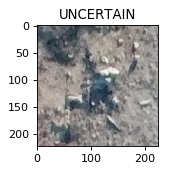

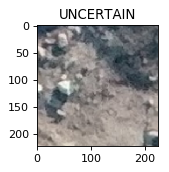

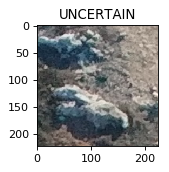

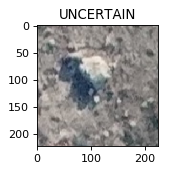

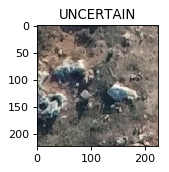

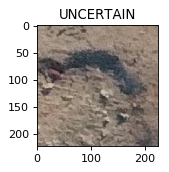

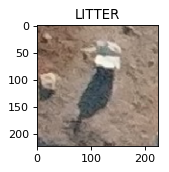

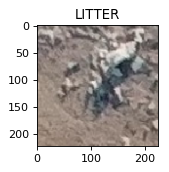

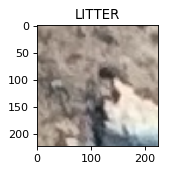

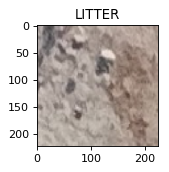

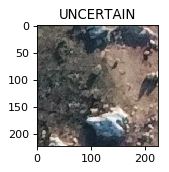

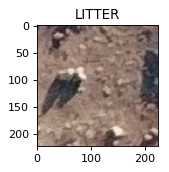

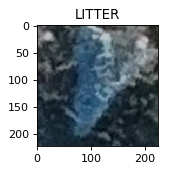

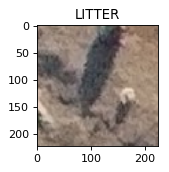

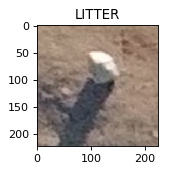

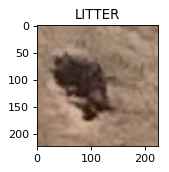

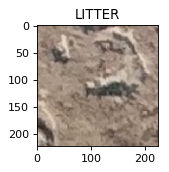

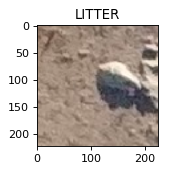

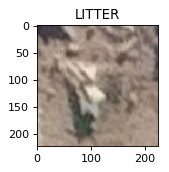

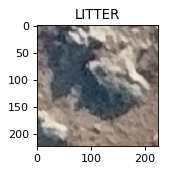

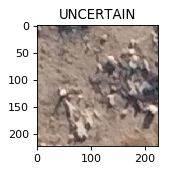

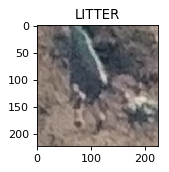

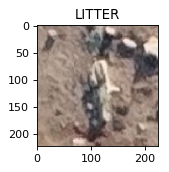

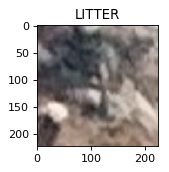

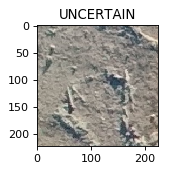

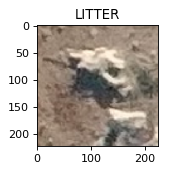

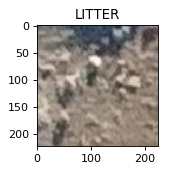

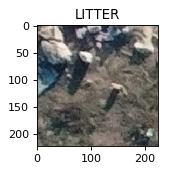

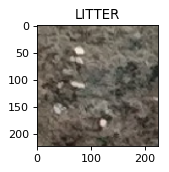

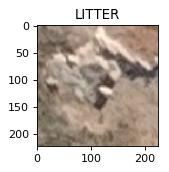

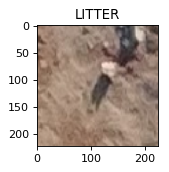

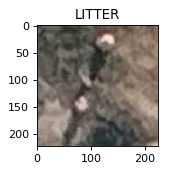

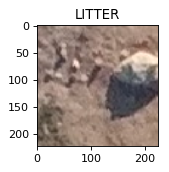

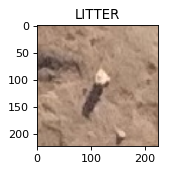

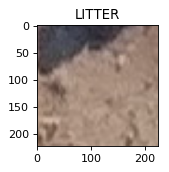

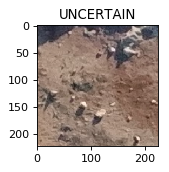

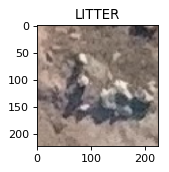

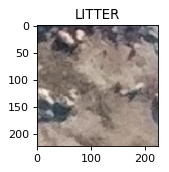

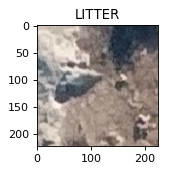

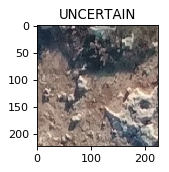

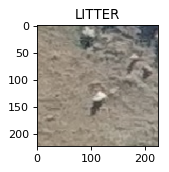

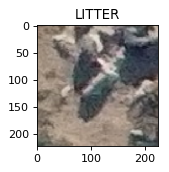

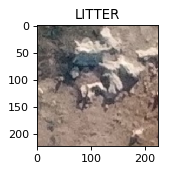

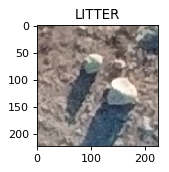

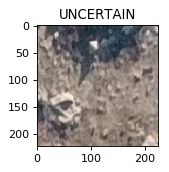

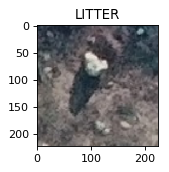

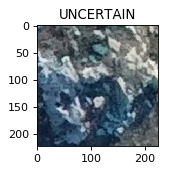

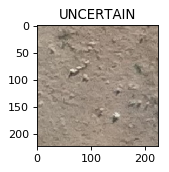

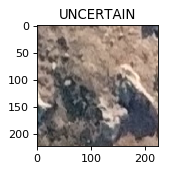

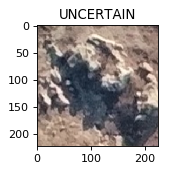

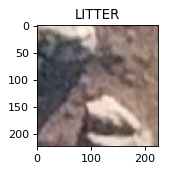

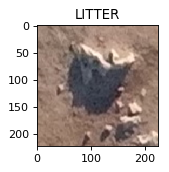

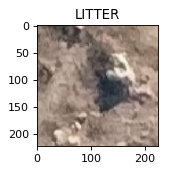

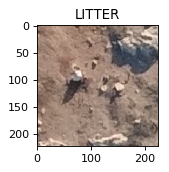

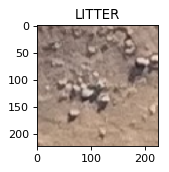

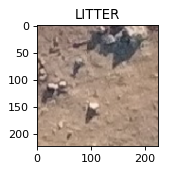

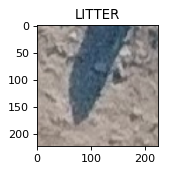

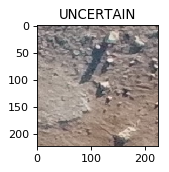

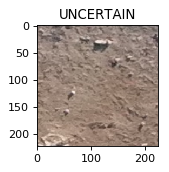

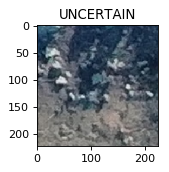

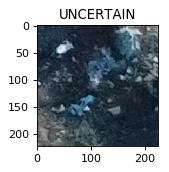

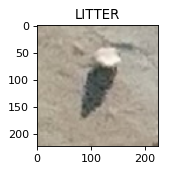

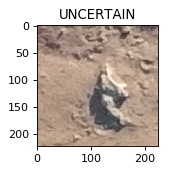

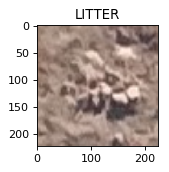

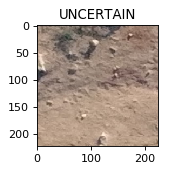

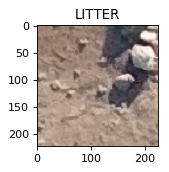

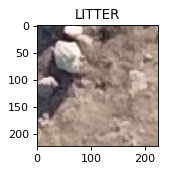

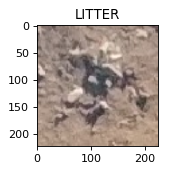

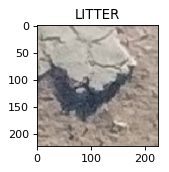

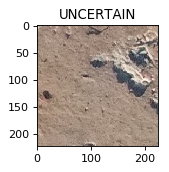

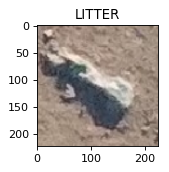

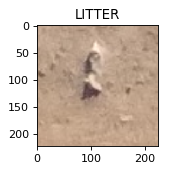

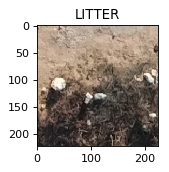

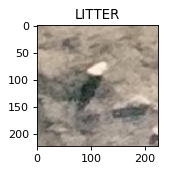

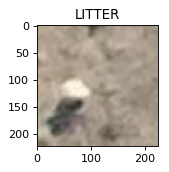

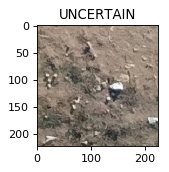

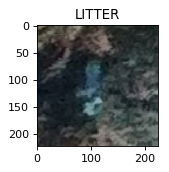

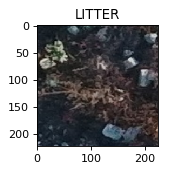

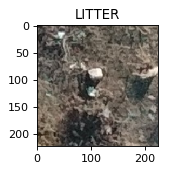

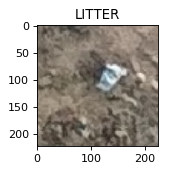

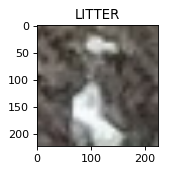

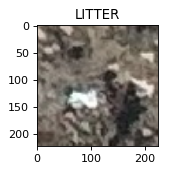

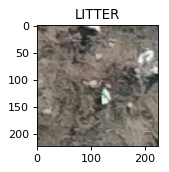

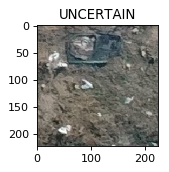

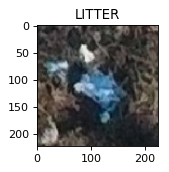

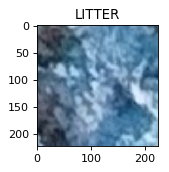

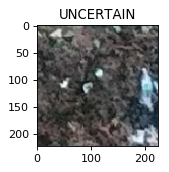

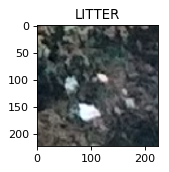

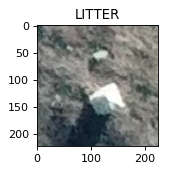

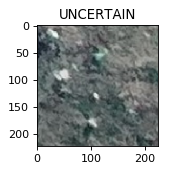

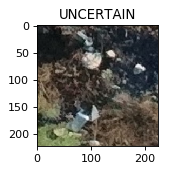

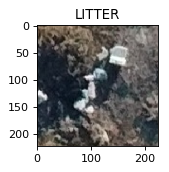

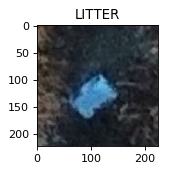

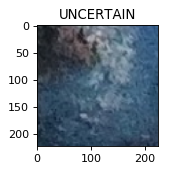

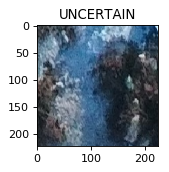

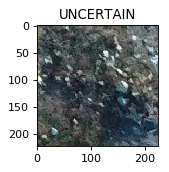

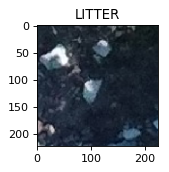

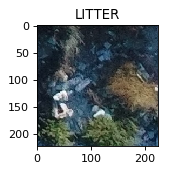

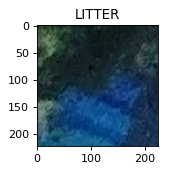

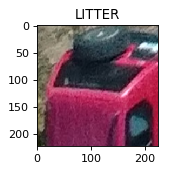

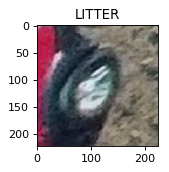

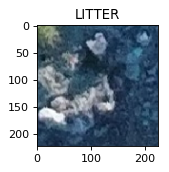

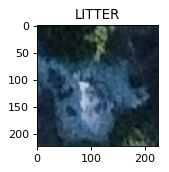

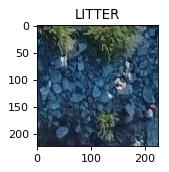

In [15]:
image=fullimage.copy()
h,w,c = fullimage.shape
no_tile_y = int(h/(crop_image_size-overlap))
no_tile_x = int(w/(crop_image_size-overlap))

for y in range(no_tile_y):
    for x in range(no_tile_x):
        if (inference_map[y][x]>0.5):
            ttx = x*(224-32)
            tty = y*(224-32)
            
            tile_image = fullimage[tty:tty+224,ttx:ttx+224,]
            
            crop_image = img_to_array(tile_image.astype("float") / 255.0)
            crop_image = np.expand_dims(crop_image, axis=0)
            centres = cam_centres(crop_image)
            for m in centres:
                tcx = max(0,m[0]-m[2])
                tcy = max(0,m[1]-m[2])
                tdx = min(224,m[0]+m[2])
                tdy = min(224,m[1]+m[2])
                zoom_tile = cv2.resize(tile_image[tcy:tdy,tcx:tdx,].copy(),(224,224))
                                
                img = img_to_array(cv2.resize(zoom_tile,(224,224)))
                img = np.expand_dims(img, axis=0)
                zoompred = zoommodel.predict(img)[0][1]
                
                if zoompred>0.5:               
                    cv2.rectangle(image,(tcx+ttx,tcy+tty),(tdx+ttx,tdy+tty),(255,0,0),5)
                    show_tile(zoom_tile,"LITTER")
                else:
                    cv2.rectangle(image,(tcx+ttx,tcy+tty),(tdx+ttx,tdy+tty),(0,0,255),5)
                    show_tile(zoom_tile,"UNCERTAIN")

            
            

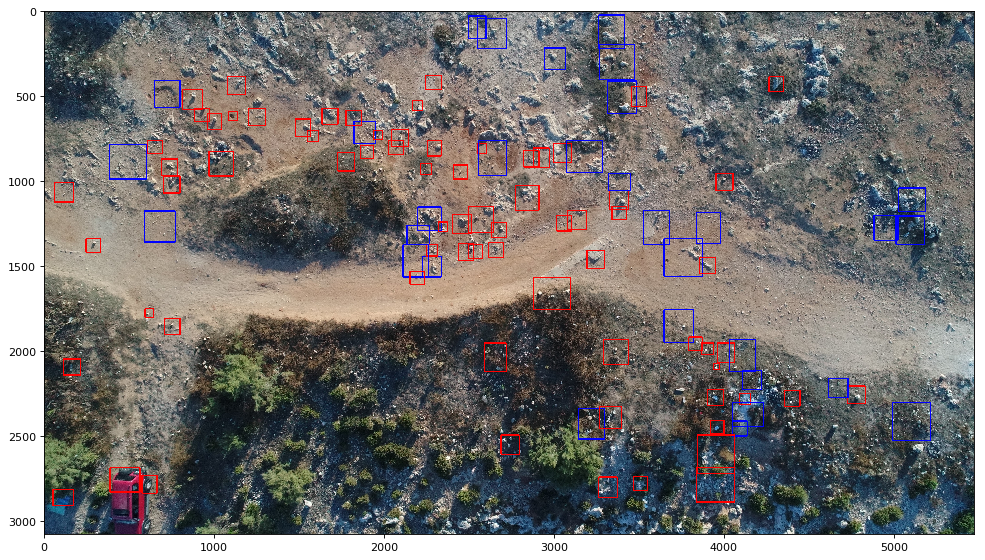

In [16]:
show_rgb(image)